## Lab 3

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [0]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are available at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [0]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text_shakespeare = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text_shakespeare = text_shakespeare[TEXT_START : TEXT_END]
assert len(text_shakespeare) == 2616

In [3]:
print(text_shakespeare[:10])

['  From fairest creatures we desire increase,\n', "  That thereby beauty's rose might never die,\n", '  But as the riper should by time decease,\n', '  His tender heir might bear his memory:\n', '  But thou, contracted to thine own bright eyes,\n', "  Feed'st thy light's flame with self-substantial fuel,\n", '  Making a famine where abundance lies,\n', '  Thy self thy foe, to thy sweet self too cruel:\n', "  Thou that art now the world's fresh ornament,\n", '  And only herald to the gaudy spring,\n']


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text_shakespeare = ''.join(s.lower() for s in text_shakespeare)

assert len(text_shakespeare) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text_shakespeare) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [0]:
words_shakespeare = text_shakespeare.split()

### Data loading: "Евгений Онегин"


In [6]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text_pushkin = iofile.readlines()
    
text_pushkin = [x.replace('\t\t', '') for x in text_pushkin]

--2020-05-26 20:21:33--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.9’

onegin.txt.9        100%[===================>] 256.37K  --.-KB/s    in 0.05s   

2020-05-26 20:21:33 (5.02 MB/s) - ‘onegin.txt.9’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [0]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text_pushkin = ''.join(s.lower() for s in text_pushkin)

Put all the characters, that you've seen in the text, into variable `tokens`.

Let's work with Shakespeare text.

In [8]:
tokens = sorted(set(text_shakespeare))
num_tokens = len(tokens)
print(num_tokens)

38


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [0]:
# dict <index>:<char>
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

# dict <char>:<index>
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [0]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.style.use('ggplot')

In [0]:
def get_random_str(main_str, substr_len, num_strings):
    strings = []
    for i in range(num_strings):
        idx = random.randrange(0, len(main_str) - substr_len + 1)
        strings.append(main_str[idx:(idx + substr_len)])
    return strings

In [0]:
def to_matrix(text, dtype='int32', batch_first = True):
    text_ix = np.zeros([len(text), len(text[0])], dtype)

    for i in range(len(text)):
        line_ix = [token_to_idx[c] for c in text[i]]
        text_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        text_ix = np.transpose(text_ix)

    return text_ix

In [0]:
def train_model(model, text, criterion, iterations: int):
    history = []
    for i in range(iterations):
        batch_ix = to_matrix(get_random_str(text, 64, 32))
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        
        logp_seq = model(batch_ix)
        predictions_logp = logp_seq[:, :-1] 
        actual_next_tokens = batch_ix[:, 1:] 

        loss = criterion(
            predictions_logp.contiguous().view(-1, num_tokens),
            actual_next_tokens.contiguous().view(-1)
        )

        opt.zero_grad()
        loss.backward()
        opt.step()

        history.append(loss.item())
        if (i+1)%100==0:
            clear_output(True)
            plt.figure(figsize=(12, 8))
            plt.plot(history, label='loss')
            plt.xlabel('Iteration number')
            plt.legend(fontsize=12)
            plt.show()

In [0]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=100, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out = char_rnn(x_sequence[:, i].view(1, -1))
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out = char_rnn(x_sequence[:, -1].view(1, -1))
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][0]
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

### Vanilla RNN

In [0]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=128, rnn_num_units=256):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return next_logits

In [0]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

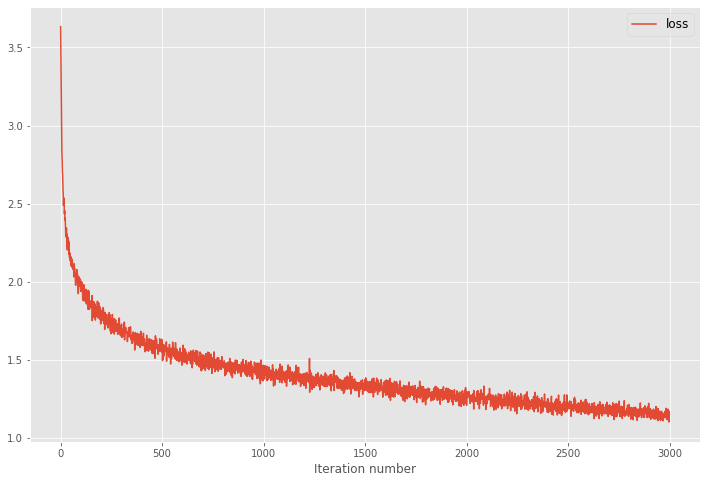

In [17]:
train_model(model, text_shakespeare, criterion, 3000)

In [18]:
# An example of generated text.
print(generate_sample(model, seed_phrase=' hello', max_length=500, temperature=0.9))

 hellone athe fover y ita my anl iqughithar pravirilino fa tis pr thangary t allfole,  pathar win ad y tere, w blithove hator t then ld  tilo if fithis, coumou athat citangh thafu by r o isilothamyolee ber whirino  plomill;
 it we!
  h ire aroule meng thy-lele,
 iry thar bed s s ber dsout ben f s wiply ss wit nglotat,  by y hy choruth ches e t we no ino s if we arus hous  kis,
 igredithof-changrit  wakn orav'd lo! is,  by?
 ivesth lounet  ch itsthoveald d blerifinunen bee  thathelund, beveth'de 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [0]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=128, rnn_num_units=256):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return next_logits

In [0]:
lstm_model = CharLSTMLoop()
opt = torch.optim.Adam(lstm_model.parameters())
criterion = nn.CrossEntropyLoss()

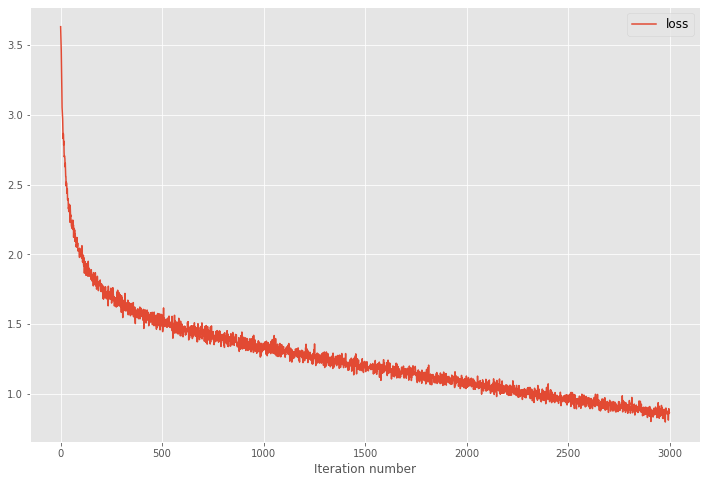

In [21]:
train_model(lstm_model, text_shakespeare, criterion, 3000)

It looks like the loss for __LSTM__ is less than the eventually obtained loss by __Vanilla RNN__.

In [22]:
print(generate_sample(lstm_model, seed_phrase='my friend', max_length=500, temperature=1.0))

my friendirour cove,
 ghetound mes al tspin   t g,
  th mandasot  imemeldoreass'thexxve
 thay cove mexce  ake po lf  ing thyeay g he lararser'dersuss thande t splinalotong phanchaboveare dery sthyengouenco by linorund merbo ame the beerme,
 morly ave'd:
 ofopimeeavees ti re gu insexxxxxxilly thounderend iis,
 imagrnde geeaug ovethouly   ipadie thive   d sthicy ay til sth ting st f i'seish idinxxxx
 pen.
 tid,
 aker l itirexxxce ancks vefofr orowhatre lly ilom  futreasha, f  fare'sin, trk!
 ighat


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [23]:
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for temp in temperatures:
    print('Generated text for temperature = {}'.format(temp))
    print(generate_sample(lstm_model, seed_phrase='my friend', max_length=500, temperature=temp))
    print('\n\n\n')

Generated text for temperature = 0.1
my friend the the the the the the the the the the the the the the the the the the the  the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the  the the the the the the the the the the the the  the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the  the the the the the  the the t




Generated text for temperature = 0.2
my friend the the th s the the the s the the the oug the  thind the the th   the the the   the the the the thand the the the the the the the  the the  the  the the the the the the the the  the the the the the the the the the theand the the the thand the  the th th the the the the  s the the the    the  the the the th the the the the thend  the the th the  the  the thath the the the the  th the the the the the the the 

### Thoughts

We see that the text, generated with the lowest _temperature_ doesn't really look like a real text, despite the fact that in this case we generated the most likely characters. However, it's not a surprise that the word __the__ appeared many times. On the other hand, the highest _temperature_ produced more chaotic text. As for me, the best _temperature_ parameter is $0.5$ or $1.0$. In general, I don't see very big difference between texts, generated by __RNN__ and __LSTM__.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [0]:
torch.save(lstm_model.state_dict(), 'checkpoint.pth')

In [25]:
new_model = CharLSTMLoop()
new_model.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

In [26]:
new_model.eval()

CharLSTMLoop(
  (emb): Embedding(38, 128)
  (rnn): LSTM(128, 256, batch_first=True)
  (hid_to_logits): Linear(in_features=256, out_features=38, bias=True)
)

In [27]:
print(generate_sample(new_model, seed_phrase='i like', max_length=500, temperature=0.9))

i likeldi ghas, t porashis gre.
 and.
 in veth thengaid  f iverere, rers th  wis,
 n thmiserthay inqumais, s owhatheane it theamilad t sen f s.
 weas  and  lfordien sthofosthorefoundanthithe mof ill th  f dos f th thed,
 ds bjouseas! n wine in  frarofome'd, bean cofilld, niloulo,   ngothal g thithinghorertall dorwithe stheesthorange bevis  m ad we,
 dindee senofour ho thisels,
 ffrs inde'd wor reto, pivofescen  sheandalomy ve byou', omy ithomalfar'thaul'se  ourth  ar  i ppsho  ch hes wofouthaty 


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)